## 1. 导入库

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 时间序列分析库
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

# 评估指标
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 设置绘图样式
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (15, 6)

print("✅ 库导入完成")

✅ 库导入完成


## 2. 加载数据

In [2]:
# 加载数据
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

# 转换时间戳
train_df['Timestamp'] = pd.to_datetime(train_df['Timestamp'])
test_df['Timestamp'] = pd.to_datetime(test_df['Timestamp'])

# 设置时间戳为索引
train_df.set_index('Timestamp', inplace=True)
test_df.set_index('Timestamp', inplace=True)

print(f"训练数据形状: {train_df.shape}")
print(f"测试数据形状: {test_df.shape}")
print(f"\n数据范围:")
print(f"训练集: {train_df.index.min()} 到 {train_df.index.max()}")
print(f"测试集: {test_df.index.min()} 到 {test_df.index.max()}")

train_df.head()

训练数据形状: (484202, 6)
测试数据形状: (2881, 5)

数据范围:
训练集: 2012-01-01 10:00:00 到 2025-10-23 23:15:00
测试集: 2025-10-23 23:30:00 到 2025-11-22 23:30:00


,Open,High,Low,Close,Volume,Target
Timestamp,,,,,,
2012-01-01 10:00:00,4.58,4.58,4.58,4.58,0.0,0.0
2012-01-01 10:15:00,4.58,4.58,4.58,4.58,0.0,0.0
2012-01-01 10:30:00,4.58,4.58,4.58,4.58,0.0,0.0
2012-01-01 10:45:00,4.58,4.58,4.58,4.58,0.0,0.0
2012-01-01 11:00:00,4.58,4.58,4.58,4.58,0.0,0.0


## 3. 数据探索和可视化

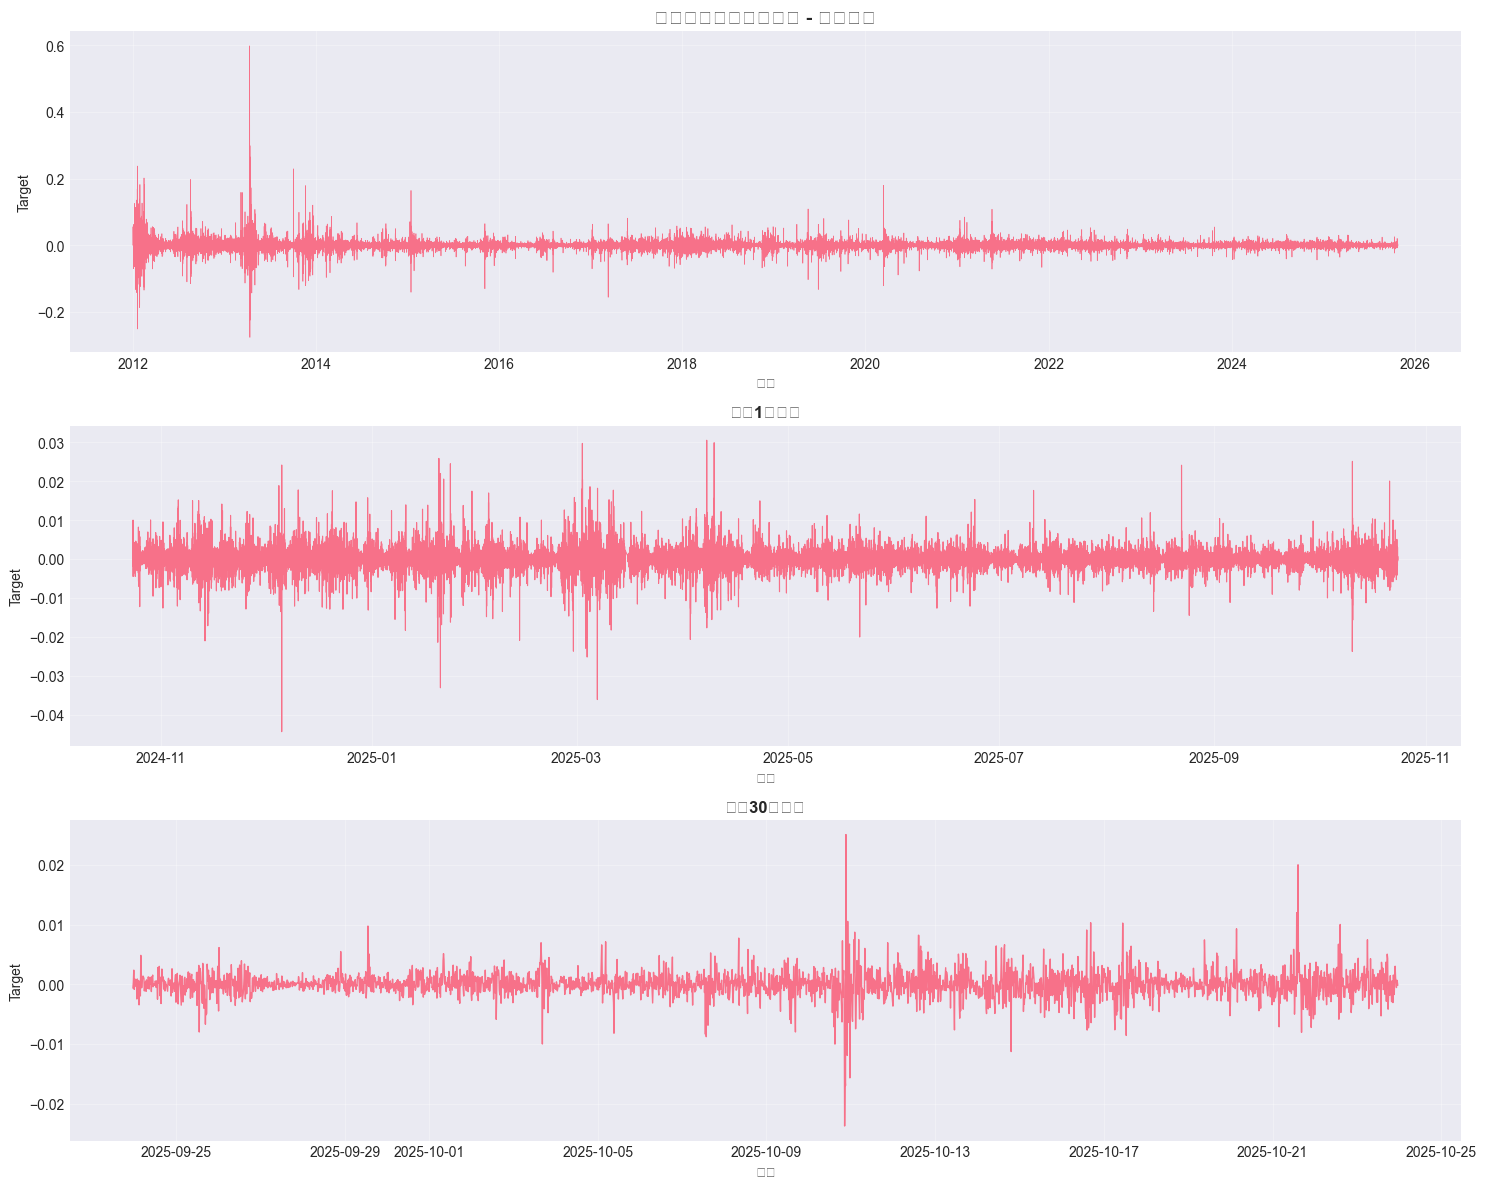

In [3]:
# 查看Target列的时间序列图
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 完整时间序列
axes[0].plot(train_df.index, train_df['Target'], linewidth=0.5)
axes[0].set_title('加密货币价格时间序列 - 完整数据', fontsize=14, fontweight='bold')
axes[0].set_xlabel('时间')
axes[0].set_ylabel('Target')
axes[0].grid(True, alpha=0.3)

# 最近1年的数据
recent_data = train_df.last('365D')
axes[1].plot(recent_data.index, recent_data['Target'], linewidth=0.8)
axes[1].set_title('最近1年数据', fontsize=12, fontweight='bold')
axes[1].set_xlabel('时间')
axes[1].set_ylabel('Target')
axes[1].grid(True, alpha=0.3)

# 最近30天的数据
recent_month = train_df.last('30D')
axes[2].plot(recent_month.index, recent_month['Target'], linewidth=1)
axes[2].set_title('最近30天数据', fontsize=12, fontweight='bold')
axes[2].set_xlabel('时间')
axes[2].set_ylabel('Target')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [4]:
# 统计描述
print("Target列统计信息:")
print(train_df['Target'].describe())
print(f"\n缺失值数量: {train_df['Target'].isna().sum()}")
print(f"零值数量: {(train_df['Target'] == 0).sum()}")

Target列统计信息:
count    484202.000000
mean          0.000021
std           0.005454
min          -0.276799
25%          -0.001275
50%           0.000000
75%           0.001384
max           0.598299
Name: Target, dtype: float64

缺失值数量: 0
零值数量: 37598


## 4. 平稳性检验 (Stationarity Test)

使用ADF检验(Augmented Dickey-Fuller Test)检查时间序列是否平稳。平稳性是ARIMA模型的前提条件。

In [5]:
def adf_test(timeseries, name=''):
    """执行ADF检验"""
    print(f'ADF检验结果 {name}:')
    print('-' * 50)
    
    result = adfuller(timeseries.dropna(), autolag='AIC')
    
    print(f'ADF统计量: {result[0]:.6f}')
    print(f'p值: {result[1]:.6f}')
    print(f'使用的滞后阶数: {result[2]}')
    print(f'观测数: {result[3]}')
    print('临界值:')
    for key, value in result[4].items():
        print(f'  {key}: {value:.3f}')
    
    if result[1] <= 0.05:
        print("\n✅ 结论: 序列是平稳的 (拒绝原假设)")
        return True
    else:
        print("\n❌ 结论: 序列不平稳 (不能拒绝原假设)")
        return False

# 对原始数据进行ADF检验
is_stationary = adf_test(train_df['Target'], '原始数据')

ADF检验结果 原始数据:
--------------------------------------------------
ADF统计量: -66.784164
p值: 0.000000
使用的滞后阶数: 98
观测数: 484103
临界值:
  1%: -3.430
  5%: -2.862
  10%: -2.567

✅ 结论: 序列是平稳的 (拒绝原假设)
ADF统计量: -66.784164
p值: 0.000000
使用的滞后阶数: 98
观测数: 484103
临界值:
  1%: -3.430
  5%: -2.862
  10%: -2.567

✅ 结论: 序列是平稳的 (拒绝原假设)


## 5. 差分处理 (Differencing)

如果数据不平稳，需要进行差分处理。

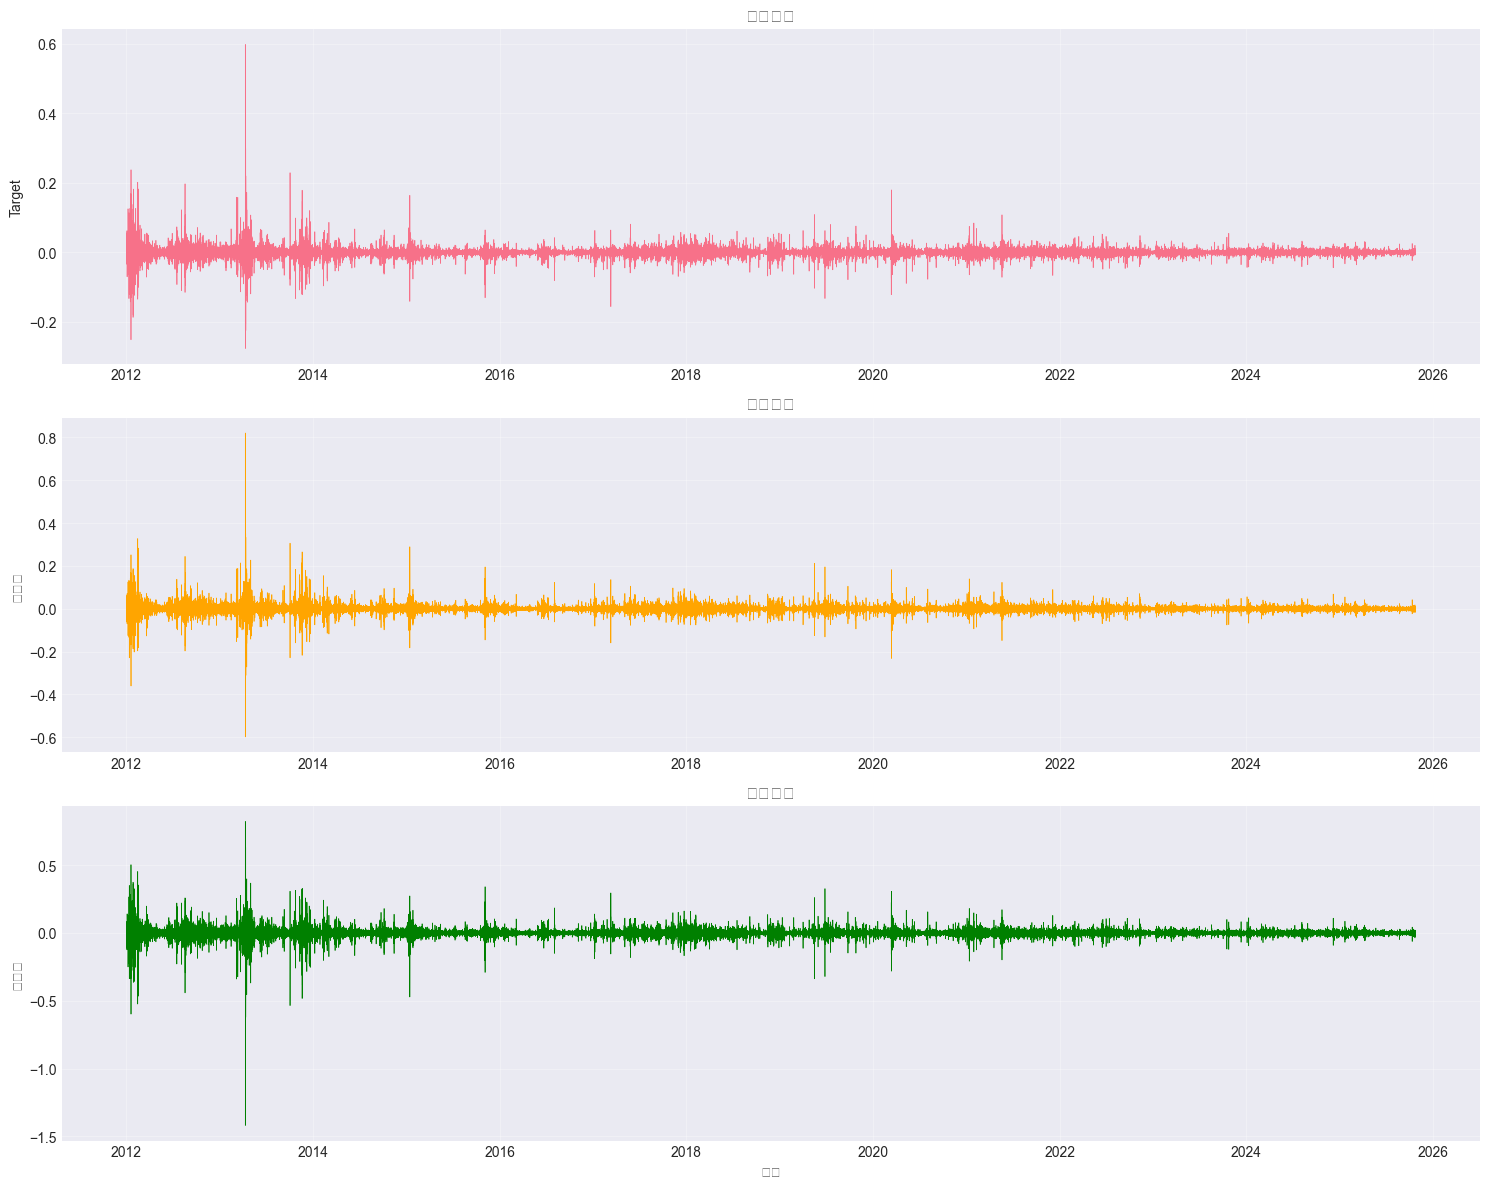



ADF检验结果 一阶差分:
--------------------------------------------------


KeyboardInterrupt: 

In [6]:
# 一阶差分
train_df['Target_diff1'] = train_df['Target'].diff()

# 二阶差分
train_df['Target_diff2'] = train_df['Target_diff1'].diff()

# 可视化差分效果
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# 原始数据
axes[0].plot(train_df.index, train_df['Target'], linewidth=0.5)
axes[0].set_title('原始数据', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Target')
axes[0].grid(True, alpha=0.3)

# 一阶差分
axes[1].plot(train_df.index, train_df['Target_diff1'], linewidth=0.5, color='orange')
axes[1].set_title('一阶差分', fontsize=12, fontweight='bold')
axes[1].set_ylabel('差分值')
axes[1].grid(True, alpha=0.3)

# 二阶差分
axes[2].plot(train_df.index, train_df['Target_diff2'], linewidth=0.5, color='green')
axes[2].set_title('二阶差分', fontsize=12, fontweight='bold')
axes[2].set_xlabel('时间')
axes[2].set_ylabel('差分值')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 对差分数据进行ADF检验
print('\n')
adf_test(train_df['Target_diff1'], '一阶差分')
print('\n')
adf_test(train_df['Target_diff2'], '二阶差分')

## 6. ACF和PACF分析

- **ACF (自相关函数)**: 衡量时间序列与其滞后值之间的相关性
- **PACF (偏自相关函数)**: 消除中间滞后影响后的相关性

### 如何解读ACF和PACF:

1. **AR(p)模型**: PACF在lag p后截断，ACF逐渐衰减
2. **MA(q)模型**: ACF在lag q后截断，PACF逐渐衰减
3. **ARMA(p,q)模型**: ACF和PACF都逐渐衰减

使用 10000 个数据点进行ACF/PACF分析


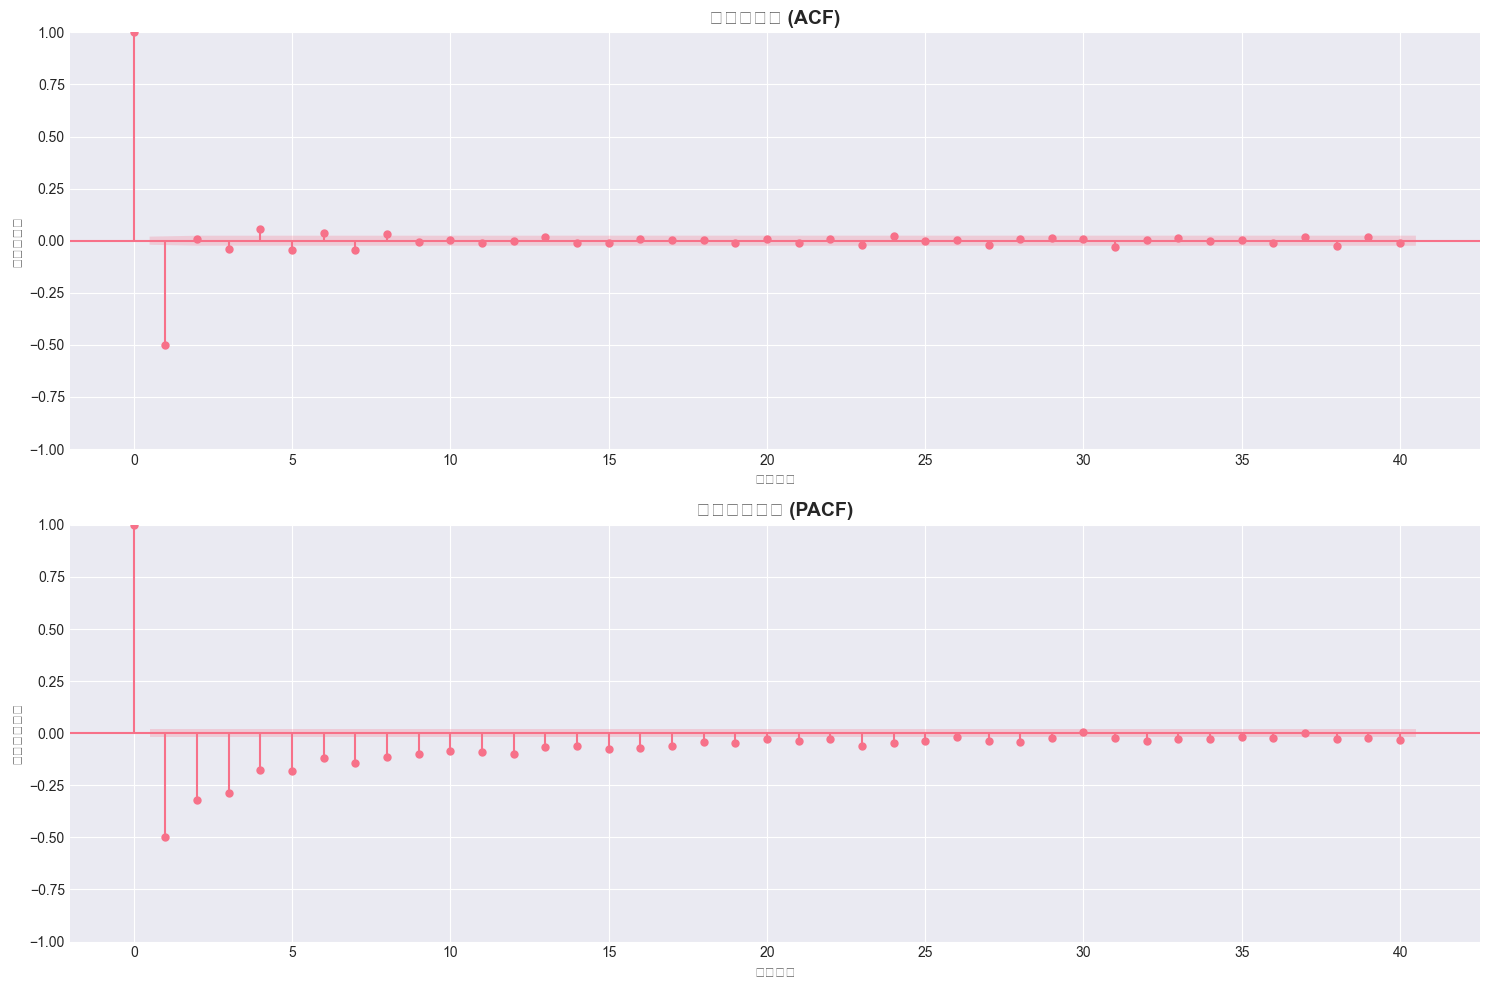

In [7]:
# 使用平稳化的数据（一阶差分）进行ACF和PACF分析
stationary_data = train_df['Target_diff1'].dropna()

# 为了加快计算，可以使用最近的数据进行分析
# 使用最近10000个数据点
sample_size = min(10000, len(stationary_data))
stationary_sample = stationary_data.iloc[-sample_size:]

print(f"使用 {len(stationary_sample)} 个数据点进行ACF/PACF分析")

# 绘制ACF和PACF图
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# ACF图
plot_acf(stationary_sample, lags=40, ax=axes[0], alpha=0.05)
axes[0].set_title('自相关函数 (ACF)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('滞后阶数')
axes[0].set_ylabel('自相关系数')

# PACF图
plot_pacf(stationary_sample, lags=40, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title('偏自相关函数 (PACF)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('滞后阶数')
axes[1].set_ylabel('偏自相关系数')

plt.tight_layout()
plt.show()

In [8]:
# 计算ACF和PACF的数值
acf_values = acf(stationary_sample, nlags=40)
pacf_values = pacf(stationary_sample, nlags=40, method='ywm')

# 找出显著的滞后阶数（超出置信区间）
confidence_interval = 1.96 / np.sqrt(len(stationary_sample))

significant_acf_lags = np.where(np.abs(acf_values[1:]) > confidence_interval)[0] + 1
significant_pacf_lags = np.where(np.abs(pacf_values[1:]) > confidence_interval)[0] + 1

print("显著的ACF滞后阶数 (前10个):")
print(significant_acf_lags[:10])
print(f"\n显著的PACF滞后阶数 (前10个):")
print(significant_pacf_lags[:10])

# 根据ACF和PACF图推荐ARIMA参数
print("\n基于ACF和PACF分析的ARIMA参数建议:")
print("="*50)

# 简单的启发式规则
if len(significant_pacf_lags) > 0:
    p_suggest = min(significant_pacf_lags[:3].max() if len(significant_pacf_lags) >= 3 else significant_pacf_lags[0], 5)
else:
    p_suggest = 1

if len(significant_acf_lags) > 0:
    q_suggest = min(significant_acf_lags[:3].max() if len(significant_acf_lags) >= 3 else significant_acf_lags[0], 5)
else:
    q_suggest = 1

print(f"建议的AR阶数 (p): {p_suggest}")
print(f"建议的差分阶数 (d): 1 (基于ADF检验结果)")
print(f"建议的MA阶数 (q): {q_suggest}")
print(f"\n建议的ARIMA模型: ARIMA({p_suggest}, 1, {q_suggest})")

显著的ACF滞后阶数 (前10个):
[ 1  3  4  5  6  7  8 23 24 27]

显著的PACF滞后阶数 (前10个):
[ 1  2  3  4  5  6  7  8  9 10]

基于ACF和PACF分析的ARIMA参数建议:
建议的AR阶数 (p): 3
建议的差分阶数 (d): 1 (基于ADF检验结果)
建议的MA阶数 (q): 4

建议的ARIMA模型: ARIMA(3, 1, 4)


## 7. 季节性分解

检查数据是否有季节性模式，这将帮助我们决定是否使用SARIMA模型。

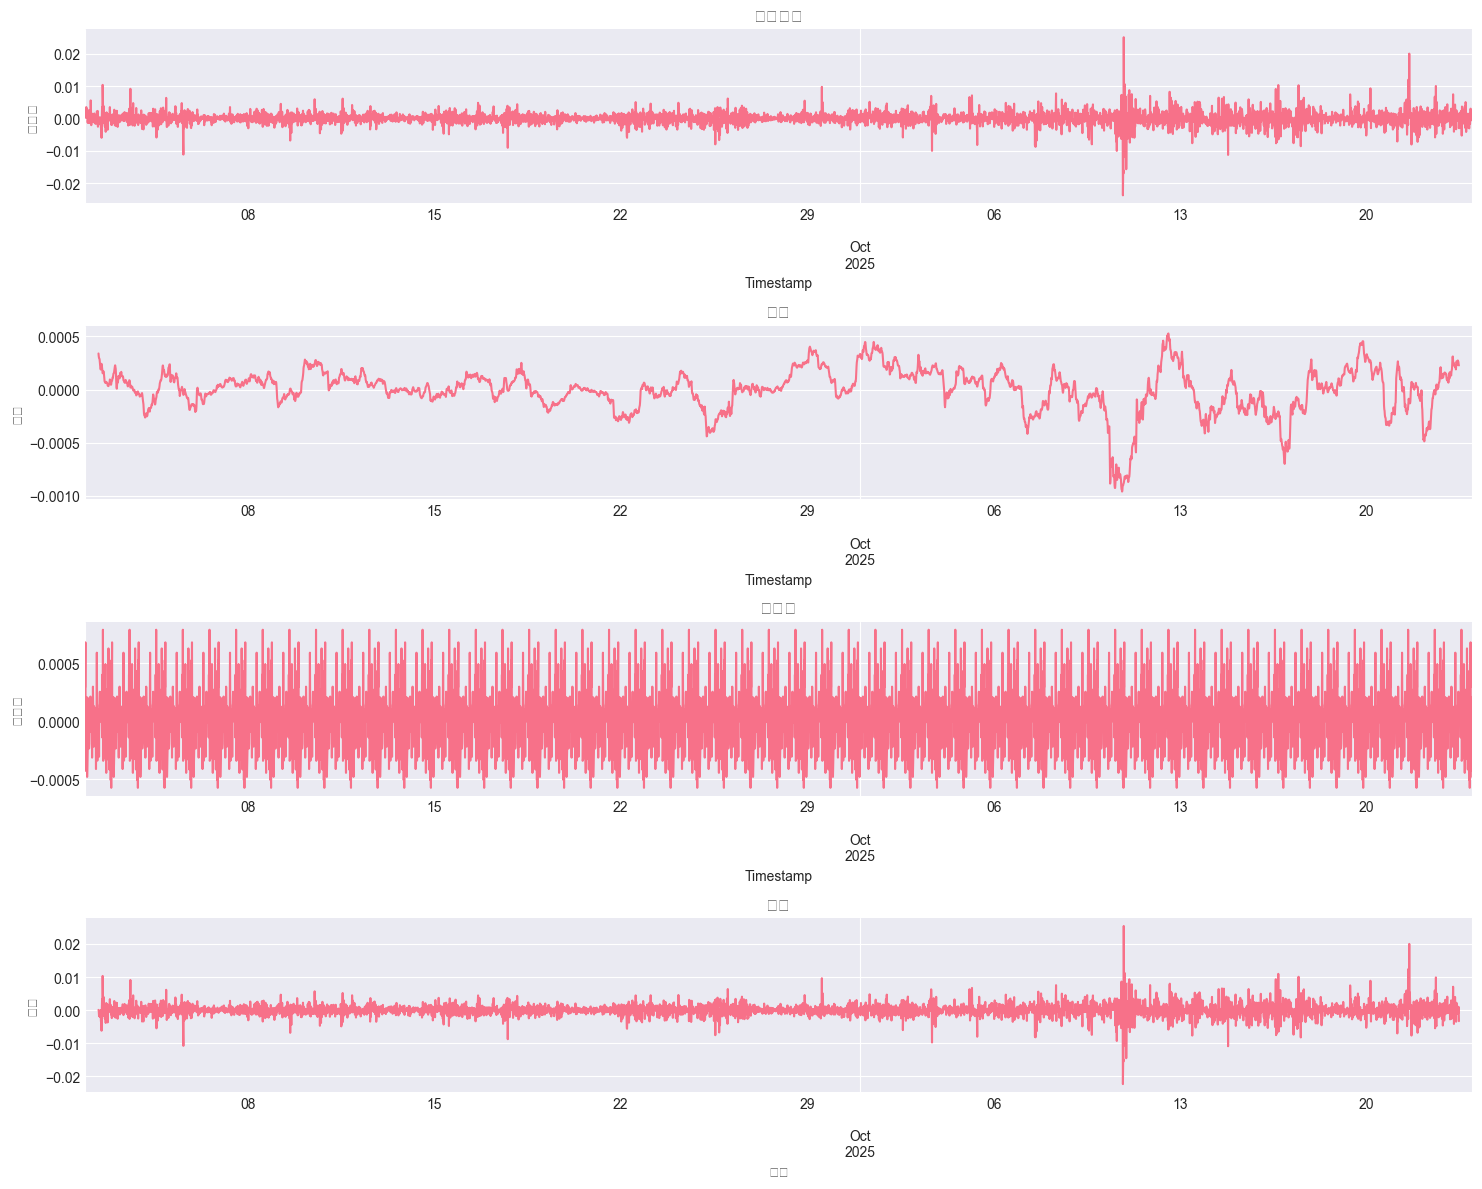

In [9]:
# 使用最近的数据进行季节性分解（加快计算速度）
decompose_sample = train_df['Target'].iloc[-5000:]

# 季节性分解（假设周期为96，因为15分钟间隔，一天有96个时间点）
# 也可以尝试其他周期，如7*96（一周）
decomposition = seasonal_decompose(decompose_sample, model='additive', period=96)

# 绘制分解结果
fig, axes = plt.subplots(4, 1, figsize=(15, 12))

decomposition.observed.plot(ax=axes[0], title='原始数据')
axes[0].set_ylabel('观测值')

decomposition.trend.plot(ax=axes[1], title='趋势')
axes[1].set_ylabel('趋势')

decomposition.seasonal.plot(ax=axes[2], title='季节性')
axes[2].set_ylabel('季节性')

decomposition.resid.plot(ax=axes[3], title='残差')
axes[3].set_ylabel('残差')
axes[3].set_xlabel('时间')

plt.tight_layout()
plt.show()

## 8. ARIMA模型训练

使用多个ARIMA配置进行网格搜索，找到最佳参数。

In [10]:
# 准备训练数据和验证数据
# 使用最后20%作为验证集
train_size = int(len(train_df) * 0.8)
train_data = train_df['Target'].iloc[:train_size]
val_data = train_df['Target'].iloc[train_size:]

print(f"训练集大小: {len(train_data)}")
print(f"验证集大小: {len(val_data)}")
print(f"训练集范围: {train_data.index.min()} 到 {train_data.index.max()}")
print(f"验证集范围: {val_data.index.min()} 到 {val_data.index.max()}")

训练集大小: 387361
验证集大小: 96841
训练集范围: 2012-01-01 10:00:00 到 2023-01-18 10:00:00
验证集范围: 2023-01-18 10:15:00 到 2025-10-23 23:15:00


In [11]:
# ARIMA网格搜索
# 为了节省时间，我们测试几个常见的配置
p_values = [0, 1, 2]
d_values = [1]
q_values = [0, 1, 2]

best_aic = np.inf
best_order = None
best_model = None

results = []

print("开始ARIMA参数网格搜索...")
print("="*70)

for p in p_values:
    for d in d_values:
        for q in q_values:
            try:
                # 使用部分数据训练以加快速度
                sample_train = train_data.iloc[-5000:]
                
                model = ARIMA(sample_train, order=(p, d, q))
                fitted = model.fit()
                
                aic = fitted.aic
                bic = fitted.bic
                
                results.append({
                    'order': (p, d, q),
                    'AIC': aic,
                    'BIC': bic
                })
                
                print(f"ARIMA{(p,d,q)} - AIC: {aic:.2f}, BIC: {bic:.2f}")
                
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, d, q)
                    best_model = fitted
                    
            except Exception as e:
                print(f"ARIMA{(p,d,q)} - 失败: {str(e)}")
                continue

print("\n" + "="*70)
print(f"最佳ARIMA模型: ARIMA{best_order}")
print(f"最佳AIC: {best_aic:.2f}")
print("="*70)

开始ARIMA参数网格搜索...
ARIMA(0, 1, 0) - AIC: -45911.61, BIC: -45905.09


/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequ

ARIMA(0, 1, 1) - AIC: -48450.92, BIC: -48437.89


/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


ARIMA(0, 1, 2) - AIC: -48729.71, BIC: -48710.16


/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


ARIMA(1, 1, 0) - AIC: -47383.02, BIC: -47369.98


/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueW

ARIMA(1, 1, 1) - AIC: -48363.86, BIC: -48344.31
ARIMA(1, 1, 2) - AIC: -48721.50, BIC: -48695.43
ARIMA(2, 1, 0) - AIC: -47723.54, BIC: -47703.99
ARIMA(1, 1, 2) - AIC: -48721.50, BIC: -48695.43
ARIMA(2, 1, 0) - AIC: -47723.54, BIC: -47703.99


/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequ

ARIMA(2, 1, 1) - AIC: -48703.89, BIC: -48677.82


/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


ARIMA(2, 1, 2) - AIC: -48910.20, BIC: -48877.62

最佳ARIMA模型: ARIMA(2, 1, 2)
最佳AIC: -48910.20


In [12]:
# 显示所有结果
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('AIC')
print("\n所有ARIMA模型结果（按AIC排序）:")
print(results_df.to_string(index=False))


所有ARIMA模型结果（按AIC排序）:
    order           AIC           BIC
(2, 1, 2) -48910.203077 -48877.618111
(0, 1, 2) -48729.706673 -48710.155693
(1, 1, 2) -48721.498302 -48695.430330
(2, 1, 1) -48703.889672 -48677.821700
(0, 1, 1) -48450.922571 -48437.888585
(1, 1, 1) -48363.860203 -48344.309224
(2, 1, 0) -47723.537122 -47703.986142
(1, 1, 0) -47383.018711 -47369.984724
(0, 1, 0) -45911.605230 -45905.088237


## 9. 使用最佳模型进行预测

In [13]:
# 使用最佳参数在完整训练集上重新训练
print(f"使用ARIMA{best_order}在完整训练集上训练...")
print("注意: 这可能需要较长时间...")

final_model = ARIMA(train_data, order=best_order)
final_fitted = final_model.fit()

print("\n模型摘要:")
print(final_fitted.summary())

使用ARIMA(2, 1, 2)在完整训练集上训练...
注意: 这可能需要较长时间...


/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWar


模型摘要:
                               SARIMAX Results                                
Dep. Variable:                 Target   No. Observations:               387361
Model:                 ARIMA(2, 1, 2)   Log Likelihood             1435029.294
Date:                Mon, 01 Dec 2025   AIC                       -2870048.589
Time:                        21:28:28   BIC                       -2869994.253
Sample:                    01-01-2012   HQIC                      -2870033.042
                         - 01-18-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.0075      0.004   -260.566      0.000      -1.015      -1.000
ar.L2         -0.0856      0.000   -261.880      0.000      -0.086      -0.085
ma.L1         -0.0777      0.004    -20.197  

In [14]:
# 在验证集上进行预测
val_predictions = final_fitted.forecast(steps=len(val_data))

# 计算评估指标
rmse = np.sqrt(mean_squared_error(val_data, val_predictions))
mae = mean_absolute_error(val_data, val_predictions)
r2 = r2_score(val_data, val_predictions)

print(f"验证集评估结果:")
print(f"  RMSE: {rmse:.6f}")
print(f"  MAE:  {mae:.6f}")
print(f"  R²:   {r2:.6f}")

验证集评估结果:
  RMSE: 0.002500
  MAE:  0.001591
  R²:   -0.004465


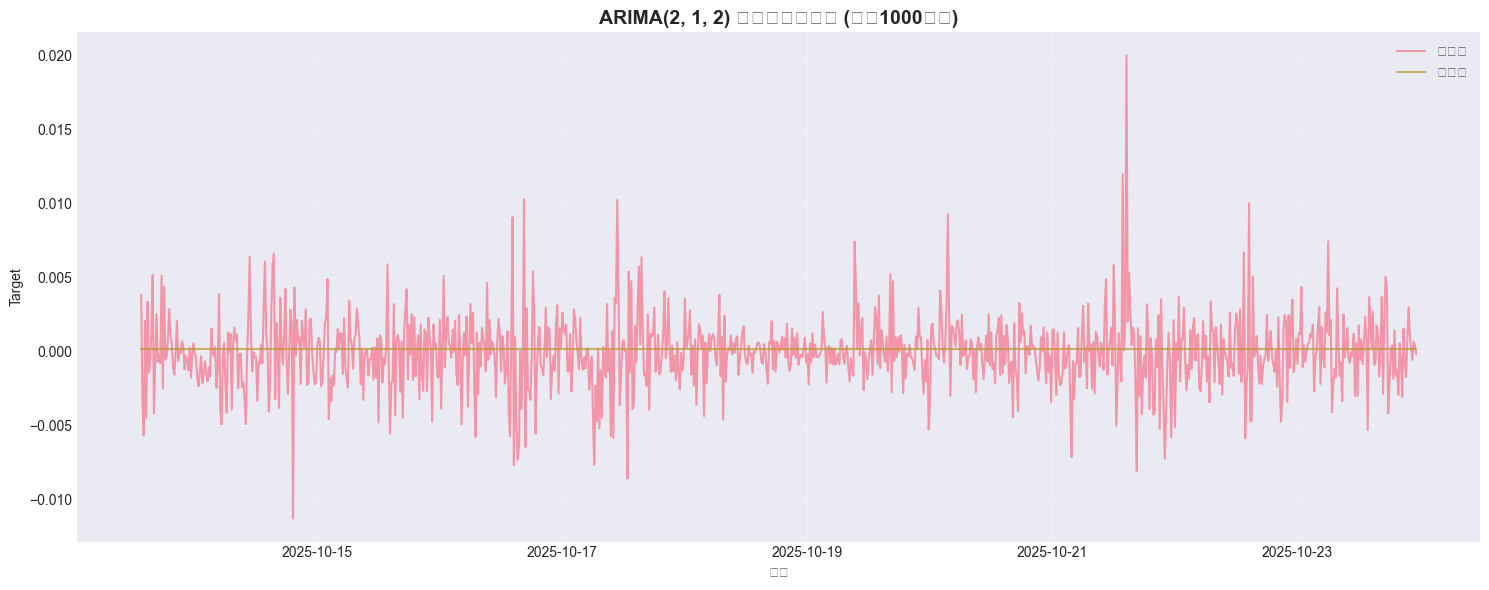

In [15]:
# 可视化验证集预测结果
plt.figure(figsize=(15, 6))

# 只显示最后1000个点，以便更清晰地看到细节
display_size = min(1000, len(val_data))

plt.plot(val_data.index[-display_size:], val_data.iloc[-display_size:], 
         label='实际值', linewidth=1.5, alpha=0.7)
plt.plot(val_data.index[-display_size:], val_predictions[-display_size:], 
         label='预测值', linewidth=1.5, alpha=0.7)

plt.title(f'ARIMA{best_order} 验证集预测结果 (最后{display_size}个点)', fontsize=14, fontweight='bold')
plt.xlabel('时间')
plt.ylabel('Target')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

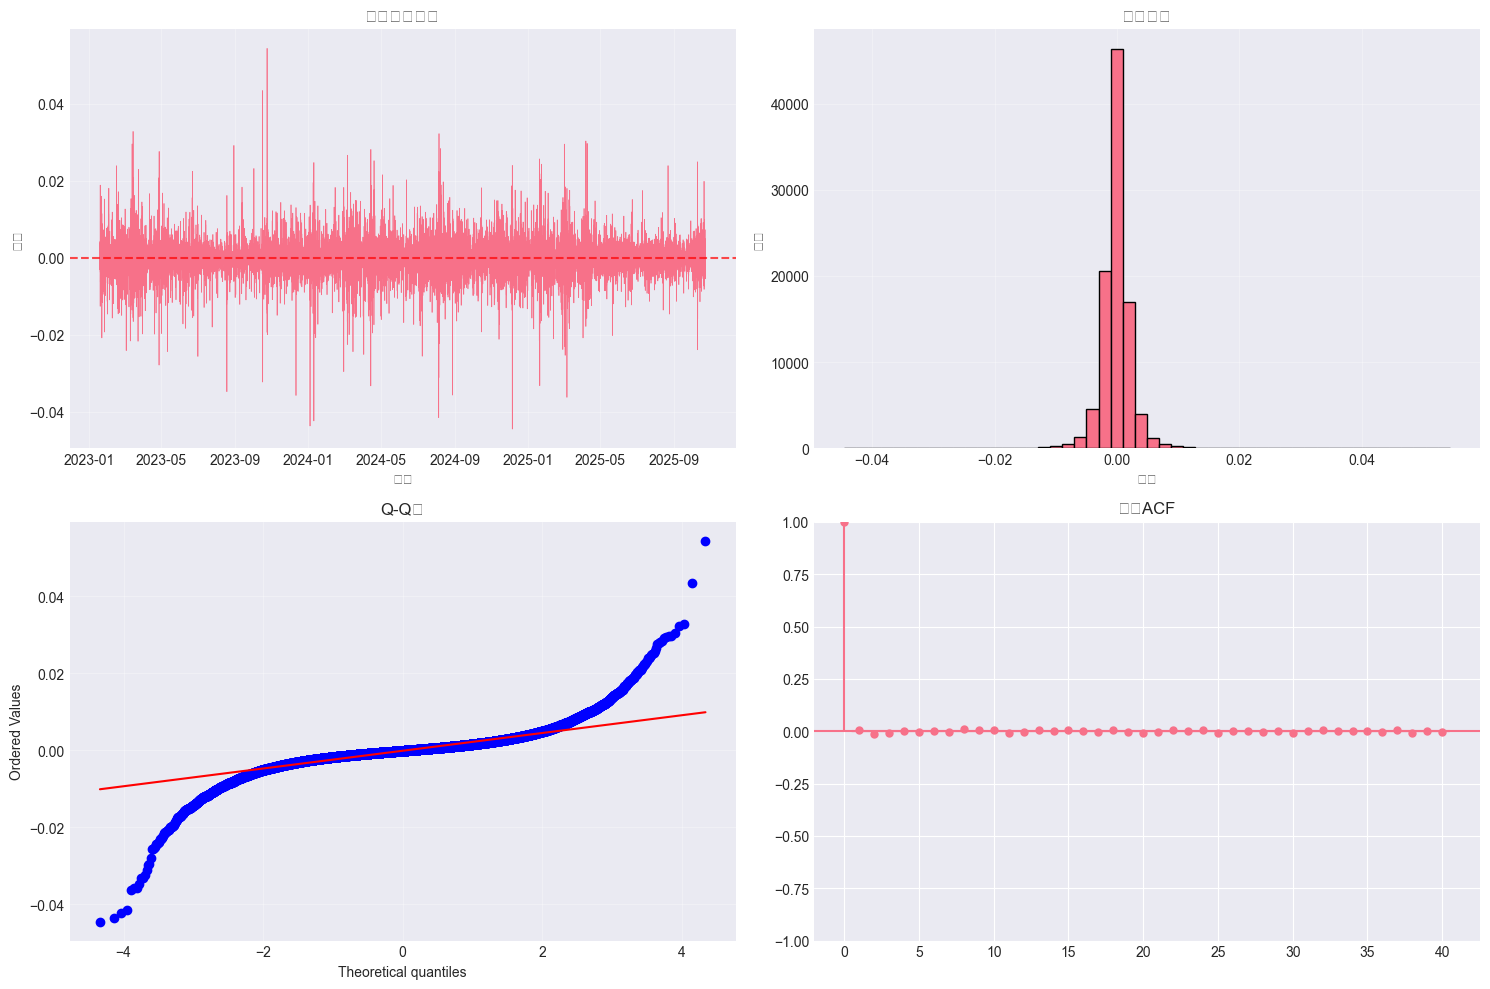

In [16]:
# 残差分析
residuals = val_data.values - val_predictions

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 残差时间序列
axes[0, 0].plot(val_data.index, residuals, linewidth=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', alpha=0.7)
axes[0, 0].set_title('残差时间序列')
axes[0, 0].set_xlabel('时间')
axes[0, 0].set_ylabel('残差')
axes[0, 0].grid(True, alpha=0.3)

# 残差分布
axes[0, 1].hist(residuals, bins=50, edgecolor='black')
axes[0, 1].set_title('残差分布')
axes[0, 1].set_xlabel('残差')
axes[0, 1].set_ylabel('频数')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q图
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q图')
axes[1, 0].grid(True, alpha=0.3)

# 残差ACF
plot_acf(residuals, lags=40, ax=axes[1, 1], alpha=0.05)
axes[1, 1].set_title('残差ACF')

plt.tight_layout()
plt.show()

## 10. 对测试集进行预测

In [17]:
# 在完整训练集上重新训练最终模型
print("在完整训练集上训练最终模型...")
final_model_full = ARIMA(train_df['Target'], order=best_order)
final_fitted_full = final_model_full.fit()

# 预测测试集
test_steps = len(test_df)
test_predictions = final_fitted_full.forecast(steps=test_steps)

print(f"\n测试集预测完成!")
print(f"预测数量: {len(test_predictions)}")
print(f"预测值范围: [{test_predictions.min():.6f}, {test_predictions.max():.6f}]")
print(f"预测值均值: {test_predictions.mean():.6f}")
print(f"预测值标准差: {test_predictions.std():.6f}")

在完整训练集上训练最终模型...


/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



测试集预测完成!
预测数量: 2881
预测值范围: [-0.000005, 0.000019]
预测值均值: 0.000007
预测值标准差: 0.000001


/opt/anaconda3/envs/6117a/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


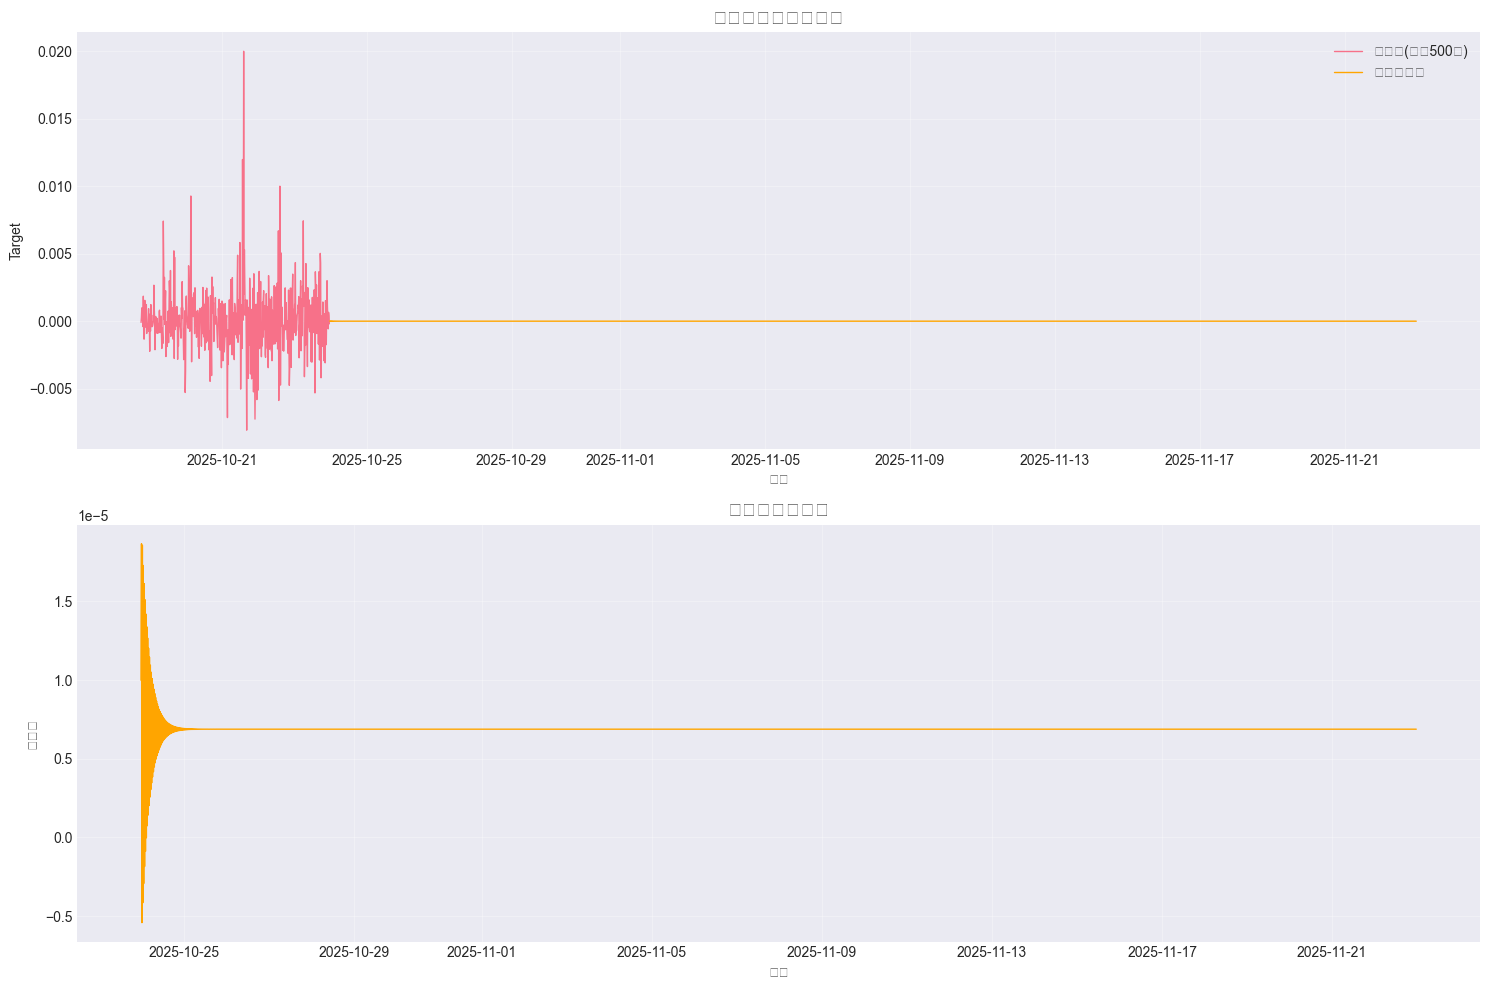

In [18]:
# 可视化测试集预测
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# 训练集最后部分和预测
last_train_points = 500
axes[0].plot(train_df.index[-last_train_points:], train_df['Target'].iloc[-last_train_points:], 
             label='训练集(最后500点)', linewidth=1)
axes[0].plot(test_df.index, test_predictions, label='测试集预测', linewidth=1, color='orange')
axes[0].set_title('训练集和测试集预测', fontsize=14, fontweight='bold')
axes[0].set_xlabel('时间')
axes[0].set_ylabel('Target')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 只显示测试集预测
axes[1].plot(test_df.index, test_predictions, linewidth=1, color='orange')
axes[1].set_title('测试集预测结果', fontsize=14, fontweight='bold')
axes[1].set_xlabel('时间')
axes[1].set_ylabel('预测值')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 11. 生成提交文件

In [ ]:
# 创建提交文件
submission_df = pd.DataFrame({
    'Timestamp': test_df.index,
    'Prediction': test_predictions  # 修改列名为 Prediction
})

# 重置索引
submission_df.reset_index(drop=True, inplace=True)

# 保存提交文件
submission_dir = Path('../submissions')
submission_dir.mkdir(exist_ok=True)

submission_file = submission_dir / 'arima_submission.csv'
submission_df.to_csv(submission_file, index=False)

print(f"✅ 提交文件已保存: {submission_file}")
print(f"\n提交文件形状: {submission_df.shape}")
print("\n提交文件预览:")
submission_df.head(10)

✅ 提交文件已保存: ../submissions/arima_submission.csv

提交文件形状: (2881, 2)

提交文件预览:


,Timestamp,Target
0,2025-10-23 23:30:00,0.000010
1,2025-10-23 23:45:00,0.000019
2,2025-10-24 00:00:00,-0.000005
3,2025-10-24 00:15:00,0.000019
4,2025-10-24 00:30:00,-0.000004
5,2025-10-24 00:45:00,0.000017
6,2025-10-24 01:00:00,-0.000003
7,2025-10-24 01:15:00,0.000016
8,2025-10-24 01:30:00,-0.000002
9,2025-10-24 01:45:00,0.000015


In [ ]:
# 提交文件统计
print("提交文件统计:")
print(submission_df['Prediction'].describe())

提交文件统计:
count    2.881000e+03
mean     6.882983e-06
std      7.304788e-07
min     -5.416879e-06
25%      6.879994e-06
50%      6.879994e-06
75%      6.879994e-06
max      1.866592e-05
Name: Target, dtype: float64


## 12. 模型诊断

检查模型的残差是否满足白噪声假设。

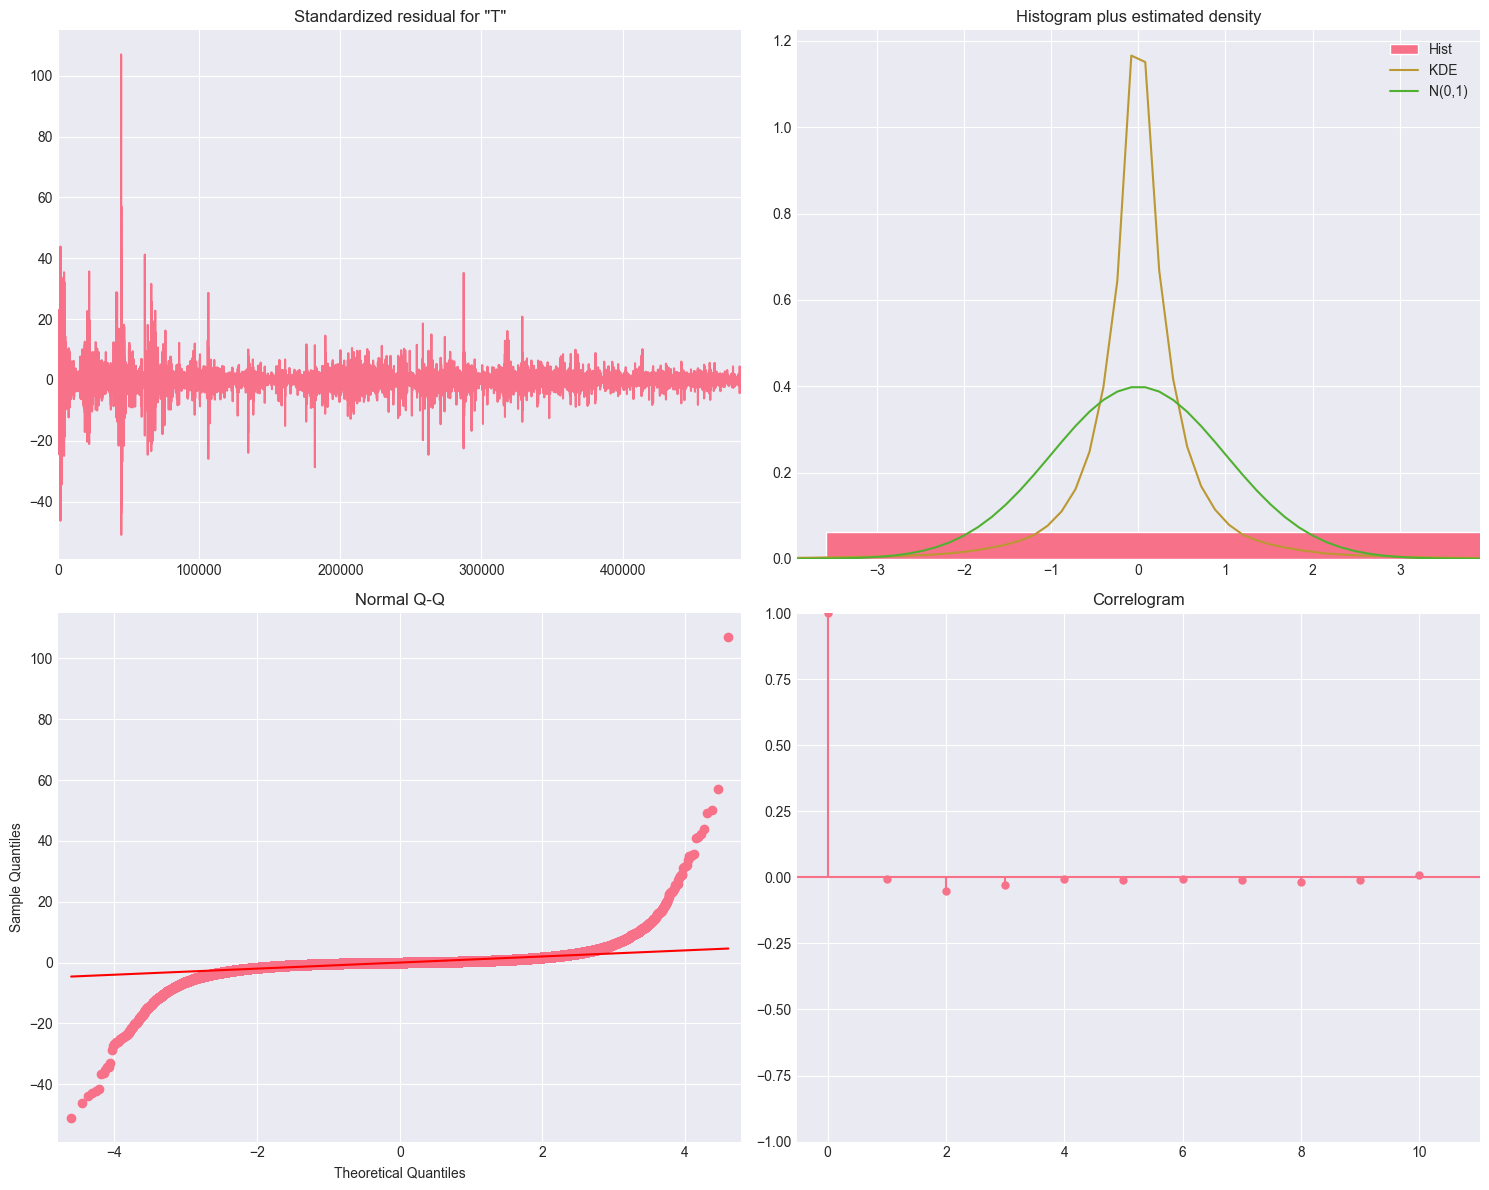

In [21]:
# 绘制模型诊断图
final_fitted_full.plot_diagnostics(figsize=(15, 12))
plt.tight_layout()
plt.show()

## 总结

### 使用的方法:
1. **平稳性检验**: 使用ADF检验确定数据的平稳性
2. **差分**: 通过差分使数据平稳
3. **ACF/PACF分析**: 确定ARIMA模型的参数(p, d, q)
4. **网格搜索**: 通过AIC/BIC选择最佳参数
5. **ARIMA建模**: 训练最佳ARIMA模型
6. **残差分析**: 验证模型的有效性

### 下一步改进:
- 尝试SARIMA模型（包含季节性）
- 使用外生变量(ARIMAX)
- 尝试更多的参数组合
- 考虑使用Prophet或其他现代时间序列模型
- 集成多个时间序列模型